In [1]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
from gmm import GMM

In [2]:
import scipy.stats as st
import sys
sys.path.append("..")
from K_Means.k_means import KMeansPlusPlus

class GMM:
    def __init__(self, k):
        self.k = k
        self.means = []
        self.covariances = []
        self.pis = []
        self.gammas = []

    def fit(self, data, eps=1e-6):
        """
        :params data: np.array of shape (..., dim)
                                  where dim is number of dimensions of point
        """
        data = np.array(data, np.float)
        self._initialize_params(data)
        
        old_means = self.get_means()
        self._E_step(data)
        self._M_step(data)
        
        while np.sum(np.square(old_means - self.means)) > eps:
            old_means = self.get_means()
            self._E_step(data)
            self._M_step(data)
            
    def _initialize_params(self, data):
        
        kmpp = KMeansPlusPlus(self.k)
        kmpp.fit(data)
        
        _, self.means = kmpp.predict(data[:1])
        
        self.covariances = np.array([np.identity(data.shape[-1])] * self.k) 
        self.pis = np.ones(self.k, np.float)/self.k
        

    def _E_step(self, data):
        normalpdfs = [st.multivariate_normal(self.means[i], self.covariances[i]).pdf
                      for i in range(self.k)]
        self.gammas = np.zeros((data.shape[0], self.k), np.float)
        for i in range(data.shape[0]):
            
            self.gammas[i] = self.pis * np.array([pdf(data[i]) for pdf in normalpdfs])
            self.gammas[i] /= self.gammas[i].sum()

    def _M_step(self, data):
        gammaSums = self.gammas.sum(axis=0)
        self.means = self.gammas.T.dot(data) /gammaSums[None].T
        
        self.covariances = np.zeros_like(self.covariances)
        for j in range(self.k):
            for i in range(data.shape[0]):
                a = (data[i] - self.means[j])
                self.covariances[j] += self.gammas[i,j] * np.outer(a, a)
            self.covariances[j] /= gammaSums[j]
            
        self.pis = gammaSums/gammaSums.sum()
        
    def predict(self, data):
        """
        :param data: np.array of shape (..., dim)
        :return: np.array of shape (...) without dims
                         each element is integer from 0 to k-1
        """
        normalpdfs = [st.multivariate_normal(self.means[i], self.covariances[i]).pdf
                      for i in range(self.k)]
        return np.array([self._pred(d, normalpdfs) for d in data])

    def _pred(self, x, normalpdfs):
        return np.argmax([pdf(x) for pdf in normalpdfs])
        
        
    def get_means(self):
        return self.means.copy()

    def get_covariances(self):
        return self.covariances.copy()

    def get_pis(self):
        return self.pis.copy()

In [3]:
def get_ellipse_from_covariance(matrix, std_multiplier=2):
    values, vectors = np.linalg.eig(matrix)
    maxI = np.argmax(values)
    large, small = values[maxI], values[1 - maxI]
    return (std_multiplier * np.sqrt(large),
            std_multiplier * np.sqrt(small),
            np.rad2deg(np.arccos(vectors[0, 0])))

In [4]:
def run_gmm(dataPath, name, K):
    df = pd.read_csv(dataPath)
    data = np.array(df[['X', 'Y']], np.float)/100000
    plt.clf()
    plt.scatter(data[:, 0], data[:, 1], s=3, color='blue')

    gmm = GMM(K)
    gmm.fit(data)
    mean = gmm.get_means()
    sigma = gmm.get_covariances()
    pi = gmm.get_pis()

    # Plot ellipses for each of covariance matrices.
    for k in range(len(sigma)):
        h, w, angle = get_ellipse_from_covariance(sigma[k])
        e = patches.Ellipse(mean[k], w, h, angle=angle)
        e.set_alpha(np.power(pi[k], .3))
        e.set_facecolor('red')
        plt.axes().add_artist(e)
    plt.savefig('covariances_{}_{}'.format(dataPath, name).replace('.','_'))
    plt.show()
    
    pred = gmm.predict(data)
    plt.figure(figsize=(20,10))
    for i in range(K):
        plt.scatter(data[pred==i,0],data[pred==i,1])
    plt.show()

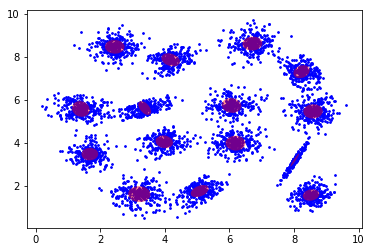

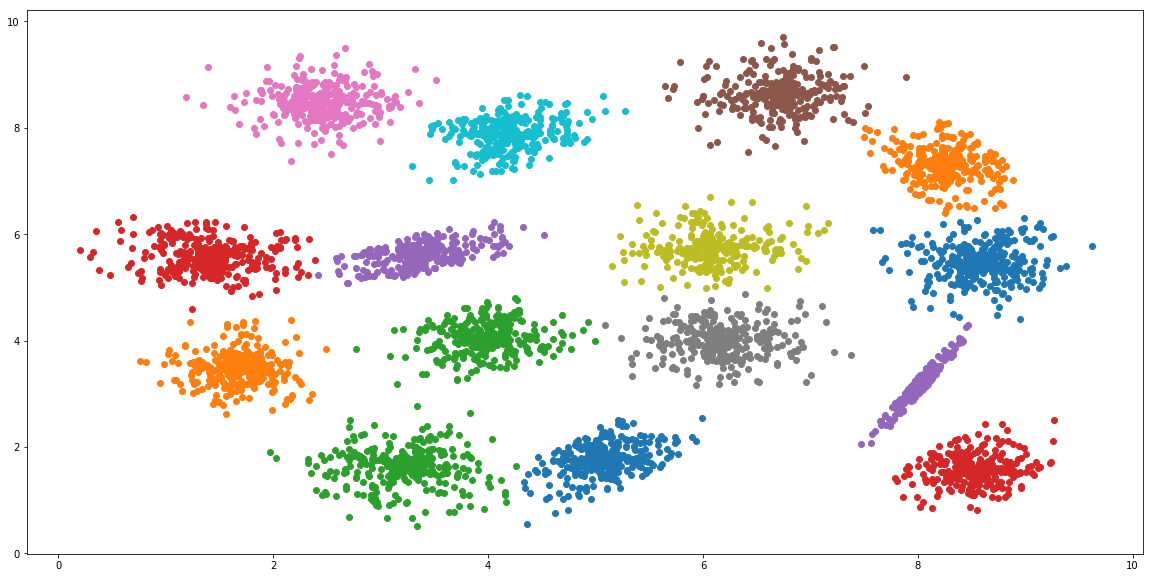

In [5]:
run_gmm("sparse_clusters.csv", "hov", 15)

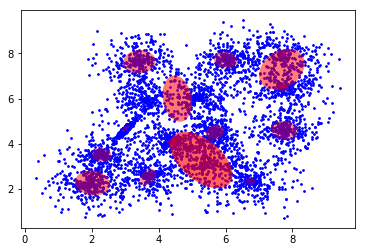

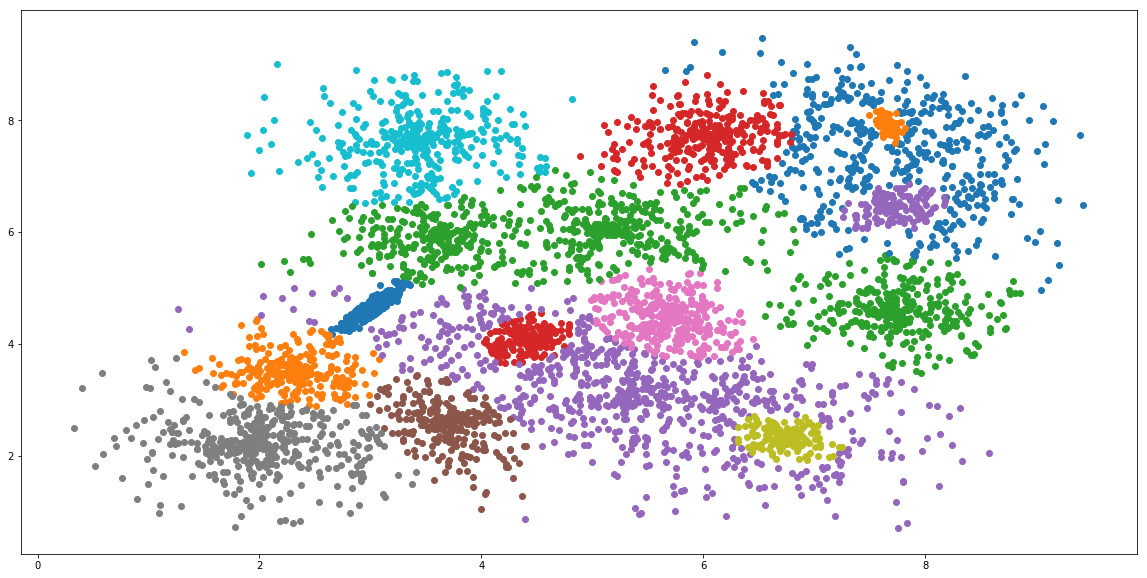

In [6]:
k=15
run_gmm("dense_clusters.csv", "hov", k)